In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as mtri


In [2]:
# Node coordinates (N, Y, Z)
nodes = {
    1: (0.0, 0.0),
    2: (0.0, 40.0),
    3: (0.0, 80.0),
    4: (0.0, 120.0),
    5: (60.0, 120.0),
    6: (60.0, 80.0),
    7: (60.0, 40.0),
    8: (60.0, 0.0),
}

# Elements (convert S4 → 2 CST triangles)
elements = {
    1: [1, 2, 7, 8],
    2: [2, 3, 6, 7],
    3: [3, 4, 5, 6],
}

# Abaqus U2, U3 values from DAT (for comparison)
abaqus_disp = {
    2: (-2.309E-02, -1.079E-02),
    3: (-3.352E-02, -2.365E-02),
    4: (-2.645E-02, -2.304E-02),
    5: ( 2.699E-03, -4.300E-03),
    6: (-9.439E-03, -1.831E-02),
    7: (-1.146E-02, -7.286E-03),
    8: ( 0.0,       0.0),
}


In [3]:
E = 40000.0
nu = 0.3
t = 0.8  # thickness

D = (E/(1-nu**2)) * np.array([[1, nu, 0],
                               [nu, 1, 0],
                               [0, 0, (1-nu)/2]])


In [4]:
# Convert quads → 2 triangles each
triangles = []
for conn in elements.values():
    n1, n2, n3, n4 = conn
    triangles.append([n1, n2, n3])
    triangles.append([n1, n3, n4])

coords_mat = np.array([nodes[i] for i in sorted(nodes.keys())])
nid_map = {nid: i for i, nid in enumerate(sorted(nodes.keys()))}


In [5]:
def tri_stiffness(n1, n2, n3):
    x1, y1 = n1
    x2, y2 = n2
    x3, y3 = n3
    A = 0.5*((x2-x1)*(y3-y1) - (x3-x1)*(y2-y1))
    B = np.array([[y2-y3, 0, y3-y1, 0, y1-y2, 0],
                  [0, x3-x2, 0, x1-x3, 0, x2-x1],
                  [x3-x2, y2-y3, x1-x3, y3-y1, x2-x1, y1-y2]])/(2*A)
    ke = t * A * (B.T @ D @ B)
    return ke


In [6]:
ndof = 2*len(nodes)
K = np.zeros((ndof, ndof))
F = np.zeros(ndof)

for tri in triangles:
    node_ids = [nid_map[n] for n in tri]
    coords = [coords_mat[i] for i in node_ids]
    ke = tri_stiffness(*coords)
    dofs = []
    for ni in node_ids:
        dofs.extend([2*ni, 2*ni+1])
    for i in range(6):
        for j in range(6):
            K[dofs[i], dofs[j]] += ke[i,j]

# Apply CLOAD: node 2, DOF=3 = 20
nid = nid_map[2]
F[2*nid+1] = 20.0

# Boundary conditions (fix nodes 1,6,8 completely)
fixed_nodes = [1,6,8]
fixed_dofs = []
for n in fixed_nodes:
    ni = nid_map[n]
    fixed_dofs += [2*ni, 2*ni+1]


In [7]:
free_dofs = np.setdiff1d(np.arange(ndof), fixed_dofs)
Kff = K[np.ix_(free_dofs, free_dofs)]
Ff = F[free_dofs]

Uf = np.linalg.solve(Kff, Ff)
U = np.zeros(ndof)
U[free_dofs] = Uf

# Displacement magnitudes per node
disp_mag = np.sqrt(U[0::2]**2 + U[1::2]**2)


In [8]:
print("Comparison with Abaqus U2, U3:")
errs = []
for nid, (abaq_u2, abaq_u3) in abaqus_disp.items():
    i = nid_map[nid]
    u2, u3 = U[2*i], U[2*i+1]
    err = np.sqrt((u2-abaq_u2)**2 + (u3-abaq_u3)**2)/(np.sqrt(abaq_u2**2+abaq_u3**2)+1e-12)
    errs.append(err)
    print(f"Node {nid}: FE=({u2:.3e}, {u3:.3e}), Abaqus=({abaq_u2:.3e}, {abaq_u3:.3e}), RelErr={err:.2%}")

print("Mean relative error:", np.mean(errs))


Comparison with Abaqus U2, U3:
Node 2: FE=(-7.959e-06, -5.910e-04), Abaqus=(-2.309e-02, -1.079e-02), RelErr=99.01%
Node 3: FE=(-9.377e-05, -5.450e-04), Abaqus=(-3.352e-02, -2.365e-02), RelErr=99.05%
Node 4: FE=(-4.114e-04, -5.427e-04), Abaqus=(-2.645e-02, -2.304e-02), RelErr=98.10%
Node 5: FE=(-3.908e-04, -2.516e-05), Abaqus=(2.699e-03, -4.300e-03), RelErr=103.89%
Node 6: FE=(0.000e+00, 0.000e+00), Abaqus=(-9.439e-03, -1.831e-02), RelErr=100.00%
Node 7: FE=(1.427e-04, -5.130e-05), Abaqus=(-1.146e-02, -7.286e-03), RelErr=100.69%
Node 8: FE=(0.000e+00, 0.000e+00), Abaqus=(0.000e+00, 0.000e+00), RelErr=0.00%
Mean relative error: 0.8582090891965216


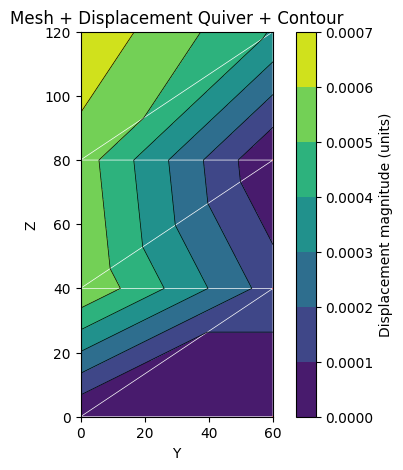

In [9]:
triang = mtri.Triangulation(coords_mat[:,0], coords_mat[:,1], [[nid_map[n] for n in tri] for tri in triangles])

plt.figure(figsize=(6,5))
plt.tricontourf(triang, disp_mag, cmap='viridis')
plt.colorbar(label='Displacement magnitude (units)')
plt.tricontour(triang, disp_mag, colors='k', linewidths=0.5)

# Undeformed mesh
plt.triplot(triang, color='white', linewidth=0.5)

# Quiver arrows (scaled)
scale = 200
plt.quiver(coords_mat[:,0], coords_mat[:,1], U[0::2], U[1::2],
           angles='xy', scale_units='xy', scale=scale, color='red')

plt.title("Mesh + Displacement Quiver + Contour")
plt.xlabel("Y"); plt.ylabel("Z")
plt.gca().set_aspect('equal')
plt.show()


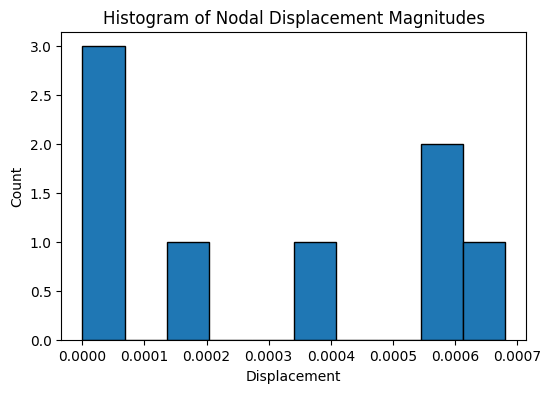

In [10]:
plt.figure(figsize=(6,4))
plt.hist(disp_mag, bins=10, edgecolor='black')
plt.title("Histogram of Nodal Displacement Magnitudes")
plt.xlabel("Displacement"); plt.ylabel("Count")
plt.show()
